# ノート 7: 畳み込みニューラルネットワーク

### 目標

CNN モデルの構築と学習を行います。

### 背景

前回までに畳み込み演算について議論しました。`sub-sevir` データセットを CNN で学習させましょう。


### Step 1: インポート


In [1]:
from pathlib import Path
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) # 不要な警告の抑止

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F


print(f"NumPy  : {np.__version__}")
print(f"Pandas : {pd.__version__}")
print(f"Xarray : {xr.__version__}")
print(f"PyTorch: {torch.__version__}")

_ = torch.manual_seed(42) # 再現性のため乱数の固定

# jupyterのカスタマイズ
%config InlineBackend.figure_format = 'retina'

NumPy  : 1.26.3
Pandas : 2.2.0
Xarray : 2024.1.1
PyTorch: 2.1.2+cpu


### Step 2: sub-SEVIR データの読み込み

ノート 1 でダウンロードしたデータセットを読み込みます。


In [2]:
save_dir = Path("../datasets/sub-sevir")
ds_train = xr.open_dataset(save_dir / "sub-sevir-train.zarr", engine="zarr")
ds_valid = xr.open_dataset(save_dir / "sub-sevir-val.zarr", engine="zarr")

ダウンロードしたデータセットは ML で学習させるための前処理が行われてたデータです。
特徴量は平均 0、標準偏差 1 に正規化され、学習・評価・テストデータセットに分割してあります。
データから学習に使う特徴量と問題（分類または回帰）に合わせたラベルを選んで使います。


### Step 3: データをテンソルに変換する

PyTorch の ML で扱うために `xr.Dataset` から `torch.Tensor` に変換します。
このチュートリアルではまず雷の有無の分類を扱います。データセットの `label_1d_class` 変数をラベルの真値とします。


In [3]:
print(ds_train)

<xarray.Dataset>
Dimensions:         (n_samples: 60000, x: 48, y: 48, n_channel: 4)
Coordinates:
    id              (n_samples) object ...
  * n_channel       (n_channel) <U5 'ir069' 'ir107' 'vil' 'vis'
  * n_samples       (n_samples) datetime64[ns] 2018-08-25T00:15:00 ... 2019-0...
Dimensions without coordinates: x, y
Data variables:
    features        (n_samples, x, y, n_channel) float32 ...
    label_1d_class  (n_samples) int8 ...
    label_1d_reg    (n_samples) int16 ...
    label_2d_class  (n_samples, x, y) int8 ...
    label_2d_reg    (n_samples, x, y) int16 ...


In [4]:
from torch.utils.data import TensorDataset, DataLoader

# データセットの作成
# PyTorch ではテンソルの次元が (B, C, H, W) なのでデータの特徴量次元を入れ替えておく
train_ds = TensorDataset(
    torch.FloatTensor(ds_train.features.values.transpose(0, 3, 1, 2)),
    torch.FloatTensor(ds_train.label_1d_class.values),
)
valid_ds = TensorDataset(
    torch.FloatTensor(ds_valid.features.values.transpose(0, 3, 1, 2)),
    torch.FloatTensor(ds_valid.label_1d_class.values),
)

`DataLoader` を作成する関数も定義しておきましょう。


In [5]:
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(
            train_ds, batch_size=bs, shuffle=True
        ),  # 訓練データのみシャッフルする
        DataLoader(valid_ds, batch_size=bs),
    )

### Step 4: Dataloader の復習

ノート 4 で学習した PyTorch の`Dataset` と `Dataloader`について復習しましょう。

計算コストや解の収束が速くなるなどの理由からミニバッチ学習がよく採用されます。
ミニバッチ学習は全学習データから計算した損失関数から勾配を求めてパラメータを更新するのではなく、
ランダムに取り出した一部のデータ（ミニバッチ）から損失関数を求め、
ミニバッチの損失関数を最適化するように重みパラメータを調整します。
実際の学習は、ミニバッチを順に取り出してパラメータを更新していき、
一巡したら再度ミニバッチを順に取り出して使います（学習データ 1 巡を 1 エポックといいます）。
エポック毎に取りだすミニバッチが同じにならないようにデータはエポック毎にランダムに取り出す必要があります。

PyTorch の `Dataloader` クラスはランダムにミニバッチを取り出すイテレータを提供します。
Step 3 ではバッチサイズを指定し訓練データがシャッフルされるように `Dataloader` を作成しました。


In [6]:
batch_size = 32
train_dl, _ = get_data(train_ds, valid_ds, batch_size)

バッチを取得するには `Dataloader` をイテレートする、つまり 1 回ループを進める必要があります。次のコードは最初のバッチを取得するためにイテレートしています。
返されるバッチは 特徴量のテンソル, ラベルのテンソル のタプルです。


In [7]:
batch = next(iter(train_dl))

xb, yb = batch
print(xb.shape, yb.shape)

torch.Size([32, 4, 48, 48]) torch.Size([32])


0 次元目が 32 になっているのはバッチサイズを 32 に指定したからです。PyTorch では 0 次元目がバッチ次元です。
バッチに含まれるデータの 1 つを可視化してみましょう。


tensor(1.)


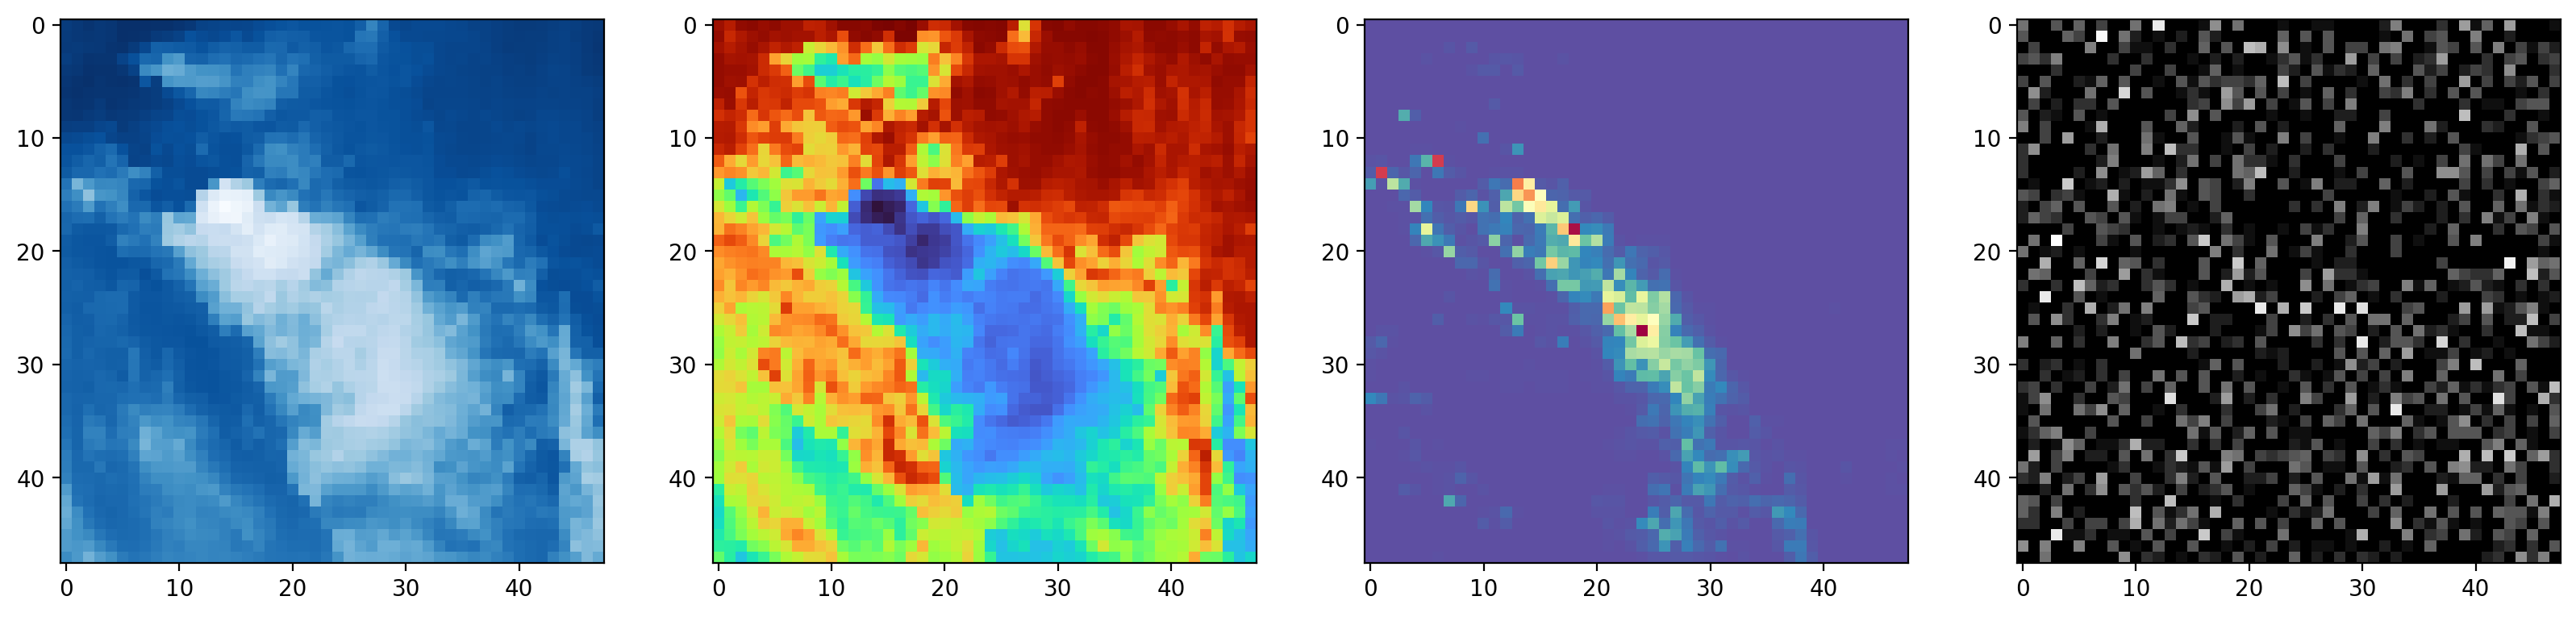

In [8]:
# 13番目のバッチの画像
one_example_features = batch[0][12]
# 13番目のバッチのラベル
one_example_label = batch[1][12]

# 画像をプロット
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
axes[0].imshow(one_example_features[0, :, :], cmap="Blues")
axes[1].imshow(one_example_features[1, :, :], cmap="turbo")
axes[2].imshow(one_example_features[2, :, :], cmap="Spectral_r")
axes[3].imshow(one_example_features[3, :, :], cmap="Greys_r")

# ラベルを表示
print(one_example_label)

`Dataloader` からもう 1 つバッチを取得して可視化してみましょう。


tensor(0.)


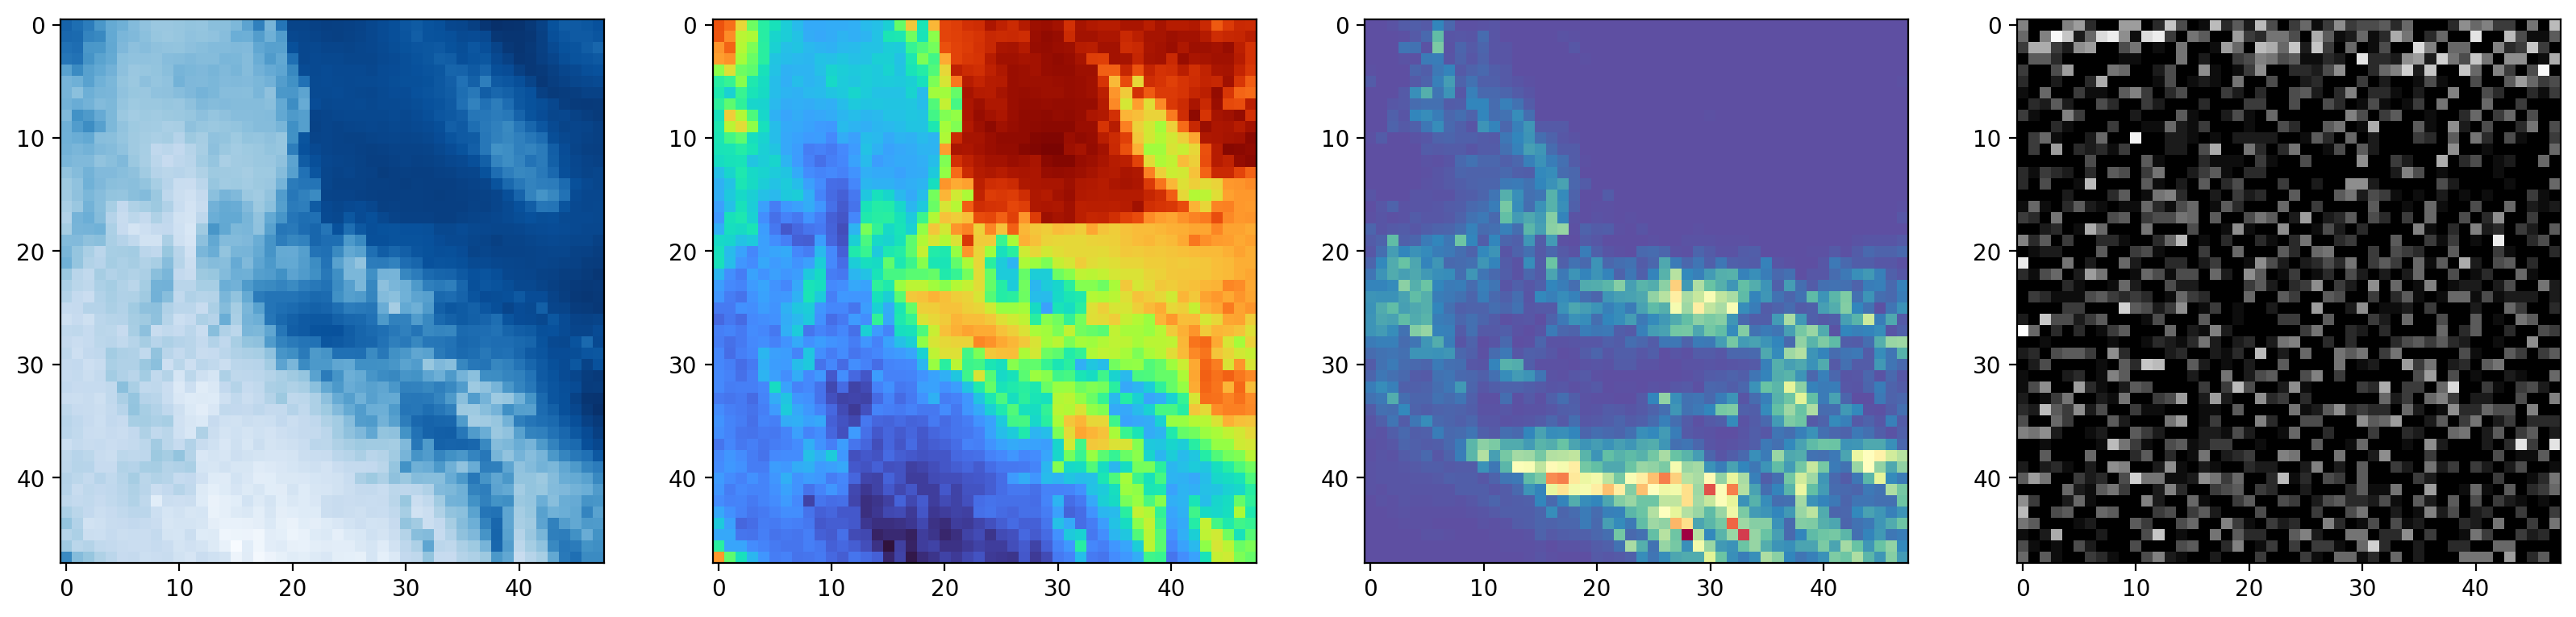

In [9]:
batch = next(iter(train_dl))

# 13番目のバッチの画像
one_example_features = batch[0][12]
# 13番目のバッチのラベル
one_example_label = batch[1][12]

# 画像をプロット
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
axes[0].imshow(one_example_features[0, :, :], cmap="Blues")
axes[1].imshow(one_example_features[1, :, :], cmap="turbo")
axes[2].imshow(one_example_features[2, :, :], cmap="Spectral_r")
axes[3].imshow(one_example_features[3, :, :], cmap="Greys_r")

# ラベルを表示
print(one_example_label)

### Step 5: CNN モデルの構築

まずは 3x3 のカーネルを持つ 1 層の畳み込み層と 1 つの特徴マップを持つモデルシンプルな CNN モデルを作成しましょう。


#### （注）カーネルの初期化

PyTorch の各層のモデルの重みはデフォルトのサンプリング法でランダムに初期化されていますが Tensorflow/Keras を使っている元論文と同じ方法ではうまく学習が進みませんでした。
このため、元論文をなるべく再現するためにカーネルとバイアスの重みを Keras のデフォルト値と同じ手法（
重みは Glorot initialization（Glorot and Bengio, 2010）、バイアスはゼロ）で初期化しなおします。

- [kernel_initializer って学習の収束に大事かも | GoodyPress](https://goody-jp.com/kernel_initializerって学習の収束に大事かも/)
- [CrossEntropyLoss - Expected object of type torch.LongTensor - vision - PyTorch Forums](https://discuss.pytorch.org/t/crossentropyloss-expected-object-of-type-torch-longtensor/28683/5)
- [tf.keras.initializers.GlorotUniform  |  TensorFlow v2.15.0.post1](https://www.tensorflow.org/api_docs/python/tf/keras/initializers/GlorotUniform)
- [torch.nn.init — PyTorch 2.2 documentation](https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.xavier_uniform_)

この後でも使えるように重みを初期化するための関数を定義しておきます。
モデルの構造だけではなく、パラメータの初期値やハイパーパラメータがモデル性能に影響する例ともいえます。


In [10]:
def init_weights(m: nn.Module) -> None:
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            m.bias = nn.init.zeros_(m.bias)

`nn.Module` を継承してモデルを定義します。`__init__()` で重みを再初期化しています。


In [11]:
class CNN1(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=4, out_channels=1, kernel_size=3)
        init_weights(self.conv1)
        self.fc1 = nn.Linear(in_features=(48 - 2) * (48 - 2), out_features=1)
        init_weights(self.fc1)
        self.flatten = nn.Flatten()

    def forward(self, xb):
        # 畳み込み層
        xb = F.relu(self.conv1(xb))
        xb = self.flatten(xb)
        # 出力層
        xb = F.sigmoid(self.fc1(xb))
        return xb

In [12]:
from torchinfo import summary

model = CNN1()

batch_size = 32
summary(model, input_size=(batch_size, 4, 48, 48))

Layer (type:depth-idx)                   Output Shape              Param #
CNN1                                     [32, 1]                   --
├─Conv2d: 1-1                            [32, 1, 46, 46]           37
├─Flatten: 1-2                           [32, 2116]                --
├─Linear: 1-3                            [32, 1]                   2,117
Total params: 2,154
Trainable params: 2,154
Non-trainable params: 0
Total mult-adds (M): 2.57
Input size (MB): 1.18
Forward/backward pass size (MB): 0.54
Params size (MB): 0.01
Estimated Total Size (MB): 1.73

### Step 6: 学習前のモデルの予測

学習前のモデルはカーネルの重みパラメータはランダムに初期化されています。
どのような予測になるか見てみましょう。


(0.0, 1.0)

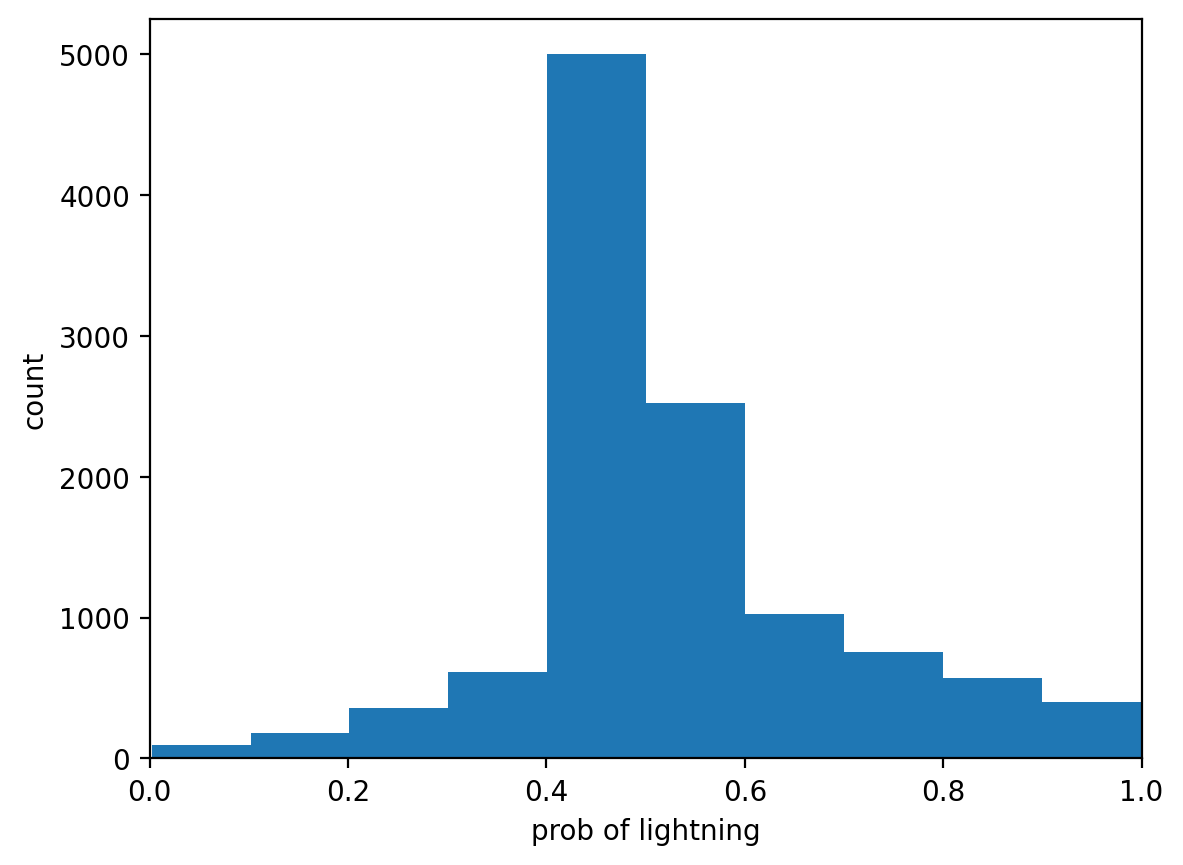

In [13]:
batch_size = 32
_, valid_dl = get_data(train_ds, valid_ds, batch_size)
model = CNN1()
model.eval()
with torch.no_grad():
    y_preds = torch.cat([model(xb) for xb, _ in valid_dl]).numpy()

plt.hist(y_preds[:, 0])
plt.xlabel("prob of lightning")
plt.ylabel("count")
plt.xlim([0, 1])

モデルの出力は [0, 1] の範囲に出力され、予測値は概ね確率分布の中心に位置しています。

パフォーマンスダイアグラムを作成してみましょう。


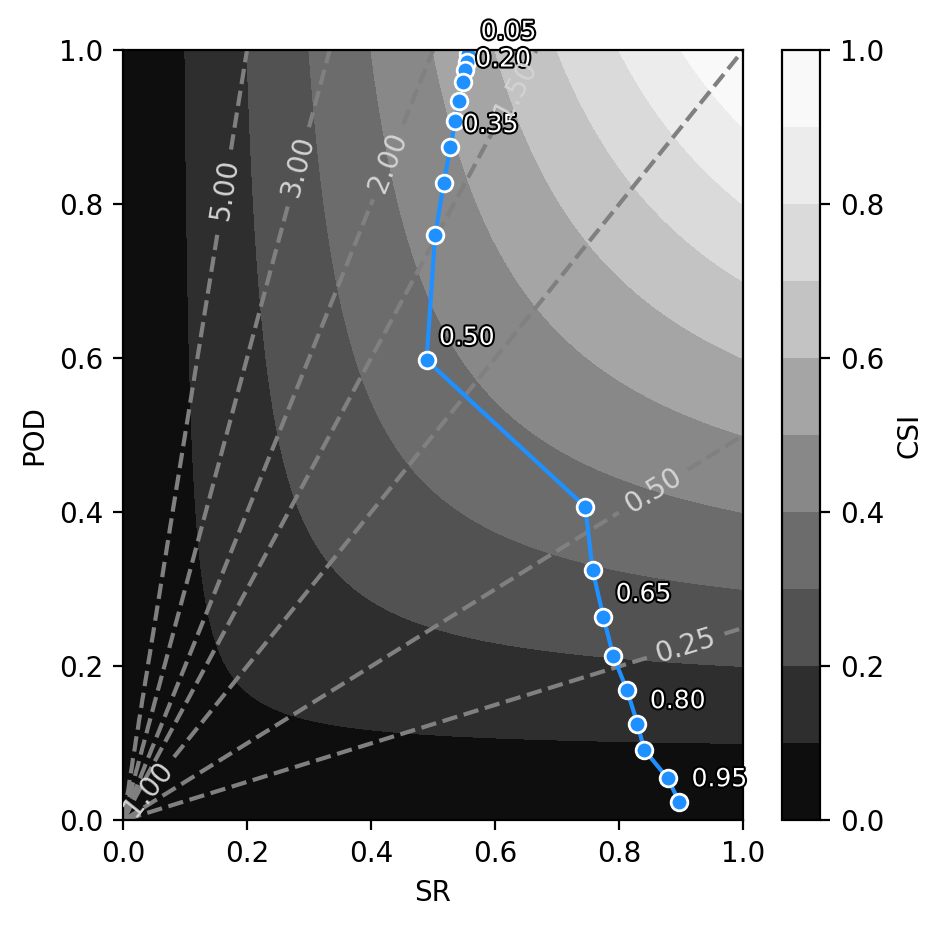

In [14]:
import matplotlib.patheffects as path_effects

# ユーティリティ関数の読み込み
import sys

sys.path.insert(1, "../scripts/")
from gewitter_functions import (
    get_contingency_table,
    get_pod,
    get_sr,
    make_performance_diagram_axis,
)


def plot_performance_diagram(y_preds, y_valid):
    # 確率の閾値
    thresholds = np.arange(0.05, 1.0, 0.05)

    pod_list = []
    sr_list = []
    # 閾値を変えながら指標を計算
    for t in thresholds:
        y_preds_bi = np.zeros(y_preds.shape, dtype=int)
        idx = np.where(y_preds >= t)
        y_preds_bi[idx] = 1

        # 検証データのラベル（真値）と予測値のラベルから分割表を作成
        cont_table = get_contingency_table(y_preds_bi, y_valid)
        pod_list.append(get_pod(cont_table))
        sr_list.append(get_sr(cont_table))

    ax = make_performance_diagram_axis()
    ax.plot(sr_list, pod_list, "o-", c="dodgerblue", mec="w")

    for i, (sr, pod, t) in enumerate(zip(sr_list, pod_list, thresholds)):
        if sr and pod and i % 3 == 0:
            text = f"{np.round(t, 2):.2f}"
            ax.text(
                sr + 0.02,
                pod + 0.02,
                text,
                fontsize=9,
                c="white",
                path_effects=[path_effects.withStroke(linewidth=1.5, foreground="k")],
            )

y_preds = y_preds[:, 0]
y_valid = valid_ds.tensors[1].numpy()
plot_performance_diagram(y_preds, y_valid)

このパフォーマンスダイアグラムにはいくつか不自然なところがあります。
学習前のモデルにしてはそれほど悪い予測ではないように見えるかもしれませんが、
検証データは雷ありとなしが同程度含まれている（雷なし：44％、雷あり：56％）ので、
ランダムな重みパラメータを使ったモデルでも（ランダムな予測でも）よいパフォーマンスを示すこともあり得ます。

また、プロットした曲線が閾値 0.5 付近で不規則に折れ曲がって見えることにも注目してください。
これは予測性能を表す曲線としては望ましい振る舞いではありません。


畳み込みのフィルターに使われるカーネルを見てみましょう。


In [15]:
# 1番目の畳み込み層の重みを取得
filters = model.conv1.weight.detach().numpy()

filters.shape

(1, 4, 3, 3)

カーネルの重みをプロットします。テンソルは [チャネル数, 特徴量数, x, y] となっていて特徴量毎のカーネルをプロットしていることに注意してください。


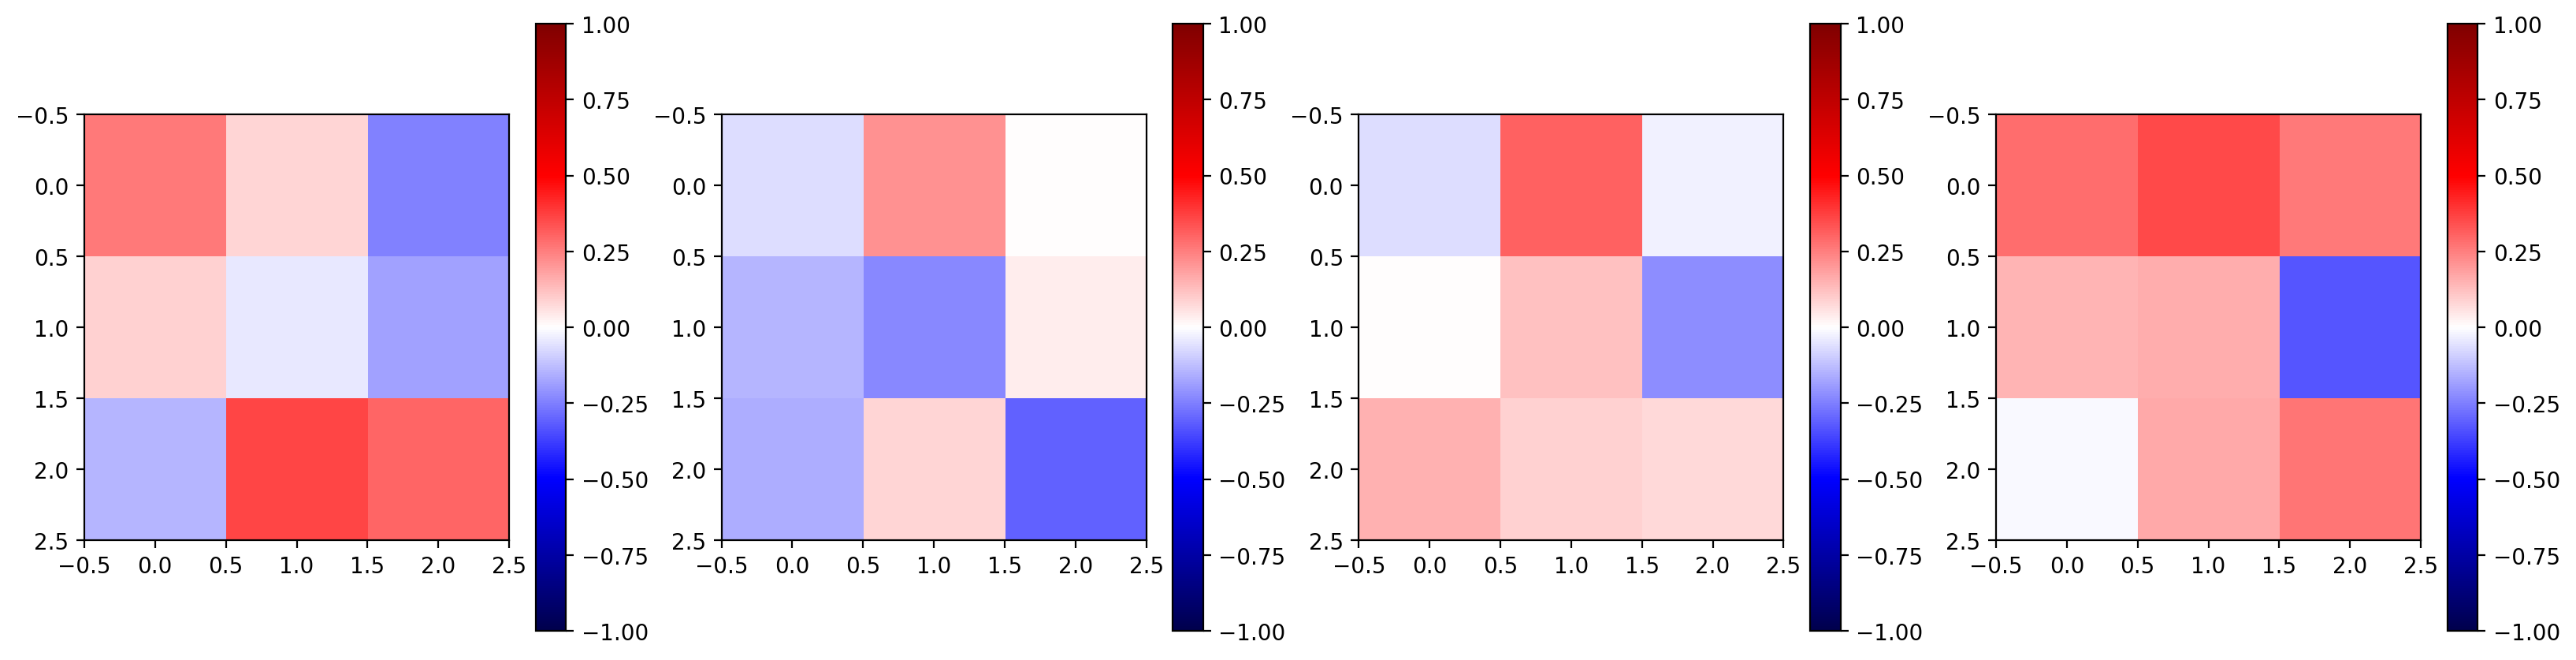

In [16]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

for i, ax in enumerate(axes):
    pm = ax.imshow(filters[0, i, :, :], vmin=-1, vmax=1, cmap="seismic")
    plt.colorbar(pm, ax=ax)

この図から得られる情報はあまりありませんがパラメータの値が正負にほぼ同じように分布しているのが分かります。
モデルを作成し初期化する段階でこうしたカーネルの分布が与えられます。

`CNN1` の畳み込み層だけを持つモデルを作成してみます。


In [17]:
conv_layer = nn.Sequential(
    model.conv1,  # 畳み込み層（活性化関数含む）部分のみ取り出す
    nn.ReLU()
)
batch_size = 32
_, valid_dl = get_data(train_ds, valid_ds, batch_size)

conv_layer.eval()
with torch.no_grad():
    xb, yb = next(iter(valid_dl))
    convolved_images = conv_layer(xb)

tensor(1.)


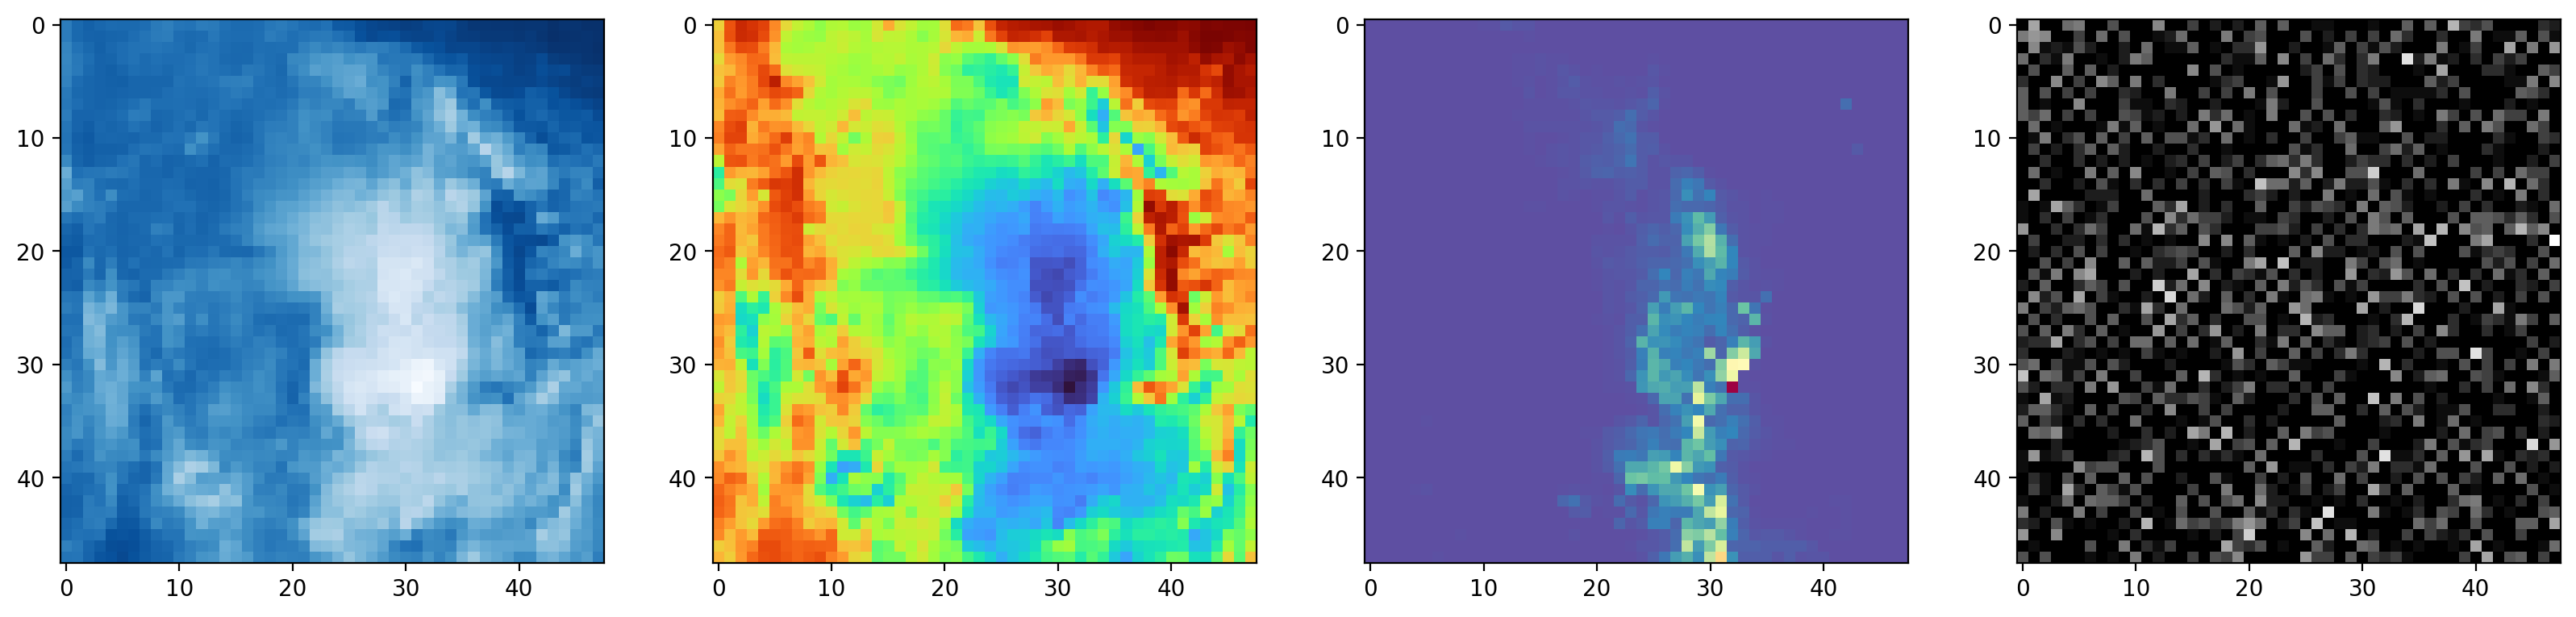

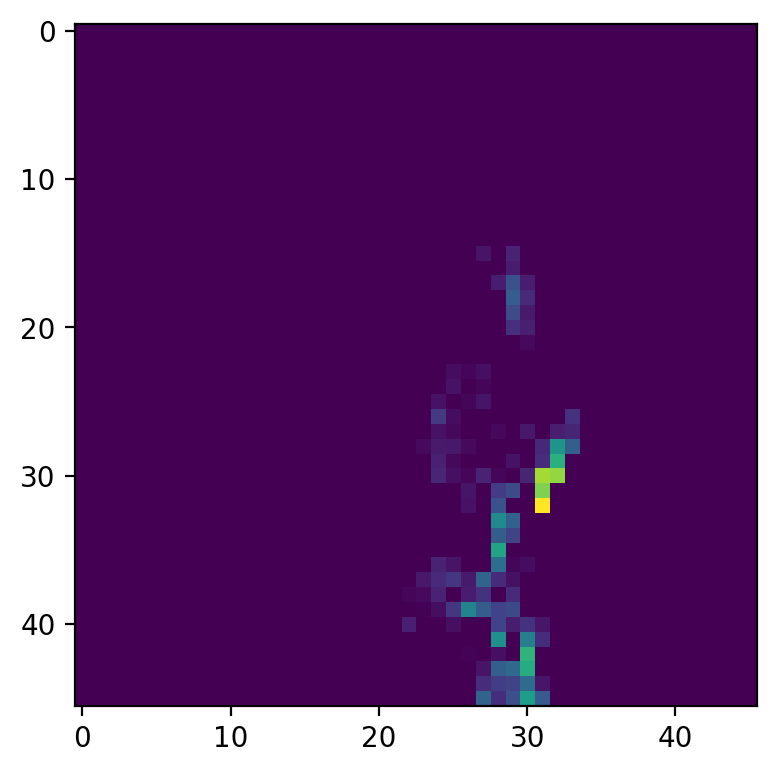

In [18]:
# バッチの0番目の画像
one_example_features = xb[0]
one_example_label = yb[0]

# 入力された画像をプロット
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
axes[0].imshow(one_example_features[0, :, :], cmap="Blues")
axes[1].imshow(one_example_features[1, :, :], cmap="turbo")
axes[2].imshow(one_example_features[2, :, :], cmap="Spectral_r")
axes[3].imshow(one_example_features[3, :, :], cmap="Greys_r")

# ラベルを表示
print(one_example_label)

# 畳み込み層の出力
_, ax = plt.subplots(1, 1, figsize=(4.4, 5))
ax.imshow(convolved_images[0, 0, :, :])

学習をしていないランダムな重みパラメータでも CNN モデルの出力は積乱雲の存在する領域を示しています。
これはおそらく、先ほどプロットしたパフォーマンスダイアグラムがそれほど悪くないように見えた理由でしょう。


### Step 7: モデルの学習

さて、少し寄り道をしてしまいましたが、いよいよモデルを学習させましょう。


In [19]:
from tqdm import tqdm

batch_size = 32
train_dl, valid_dl = get_data(train_ds, valid_ds, batch_size)

loss_fn = torch.nn.BCELoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=1e-3)

train_losses = []
valid_losses = []
epochs = np.arange(0, 20)  # 20エポック
for epoch in epochs:
    print(f"Epoch {epoch+1}/{len(epochs)}")

    # 学習
    model.train()
    train_loss = 0
    for xb, yb in tqdm(train_dl, total=len(train_dl)):
        pred = model(xb)
        loss = loss_fn(pred, yb.view(-1, 1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() 
    train_loss = train_loss / len(train_dl)  # 1エポックの損失
    train_losses.append(train_loss)

    # 評価
    model.eval()
    valid_loss = 0
    with torch.no_grad():
        for xb, yb in valid_dl:
            pred = model(xb)
            loss = loss_fn(pred, yb.view(-1, 1))
            valid_loss += loss.item() 
    valid_loss = valid_loss / len(valid_dl)  # 1エポックの損失
    valid_losses.append(valid_loss)

Epoch 1/20


100%|██████████| 1875/1875 [00:04<00:00, 397.86it/s]


Epoch 2/20


100%|██████████| 1875/1875 [00:04<00:00, 395.33it/s]


Epoch 3/20


100%|██████████| 1875/1875 [00:04<00:00, 392.09it/s]


Epoch 4/20


100%|██████████| 1875/1875 [00:04<00:00, 404.42it/s]


Epoch 5/20


100%|██████████| 1875/1875 [00:04<00:00, 397.71it/s]


Epoch 6/20


100%|██████████| 1875/1875 [00:04<00:00, 399.33it/s]


Epoch 7/20


100%|██████████| 1875/1875 [00:04<00:00, 393.74it/s]


Epoch 8/20


100%|██████████| 1875/1875 [00:04<00:00, 402.44it/s]


Epoch 9/20


100%|██████████| 1875/1875 [00:04<00:00, 404.53it/s]


Epoch 10/20


100%|██████████| 1875/1875 [00:04<00:00, 398.20it/s]


Epoch 11/20


100%|██████████| 1875/1875 [00:04<00:00, 393.34it/s]


Epoch 12/20


100%|██████████| 1875/1875 [00:04<00:00, 397.64it/s]


Epoch 13/20


100%|██████████| 1875/1875 [00:04<00:00, 398.61it/s]


Epoch 14/20


100%|██████████| 1875/1875 [00:04<00:00, 402.92it/s]


Epoch 15/20


100%|██████████| 1875/1875 [00:04<00:00, 399.33it/s]


Epoch 16/20


100%|██████████| 1875/1875 [00:04<00:00, 405.09it/s]


Epoch 17/20


100%|██████████| 1875/1875 [00:04<00:00, 406.35it/s]


Epoch 18/20


100%|██████████| 1875/1875 [00:04<00:00, 406.26it/s]


Epoch 19/20


100%|██████████| 1875/1875 [00:04<00:00, 395.63it/s]


Epoch 20/20


100%|██████████| 1875/1875 [00:04<00:00, 400.30it/s]


PC の性能にもよりますが少し時間がかかると思います。


### Step 8: 過学習の確認

モデルが過学習をしていないかを確認しましょう。訓練データと検証データの損失関数をプロットして学習曲線を比較します。


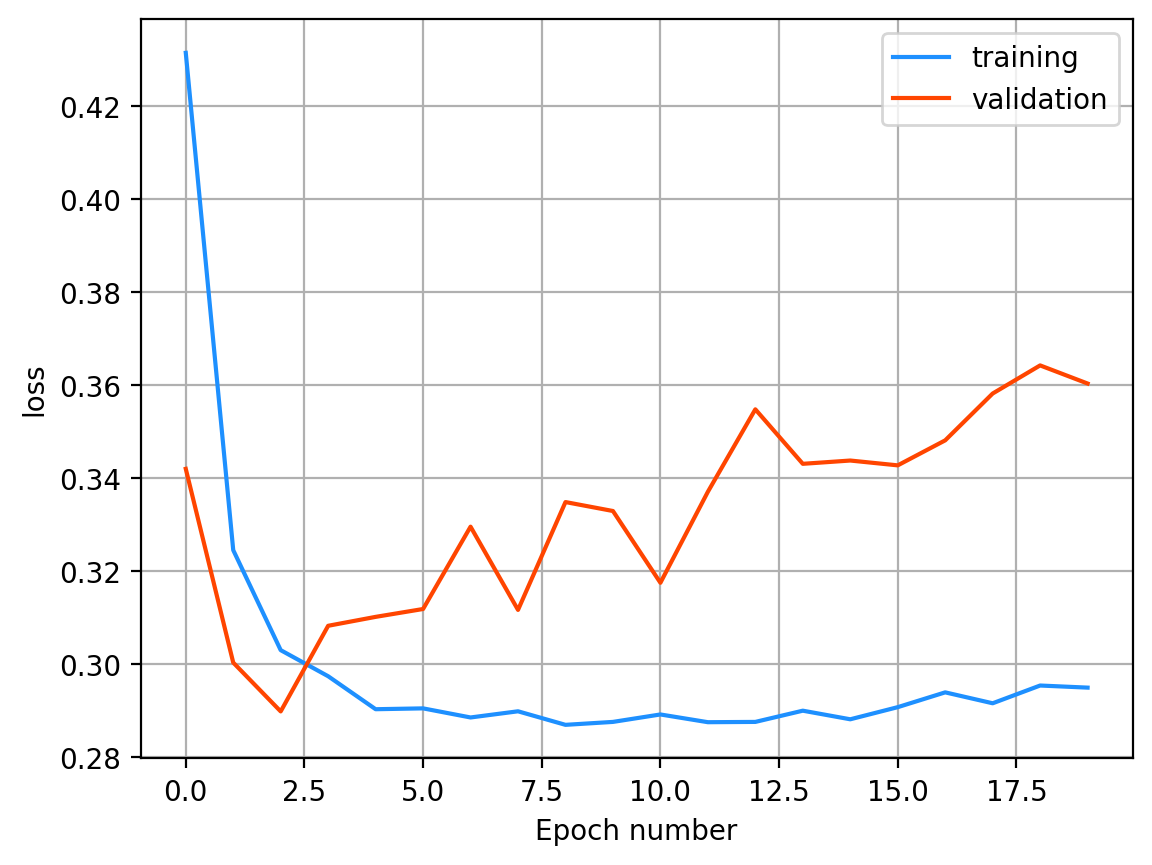

In [20]:
plt.plot(train_losses, color="dodgerblue", label="training")
plt.plot(valid_losses, color="orangered", label="validation")
plt.legend()
plt.xlabel("Epoch number")
plt.ylabel("loss")
plt.grid()

過学習かどうか判断できるでしょうか？
過学習が起きている場合、訓練データの学習曲線が低下する一方で評価データの学習曲線が上昇するのでした。

この例では訓練データの学習曲線は低下する一方で、評価データの学習曲線がエポック数 5 あたりから増加を始めており
モデルの過学習が始まっていると考えられます。性能についても評価してみましょう。


### Step 9: 性能の確認

学習済みモデルの出力とパフォーマンスダイアグラムで予測性能を確認します。


(0.0, 1.0)

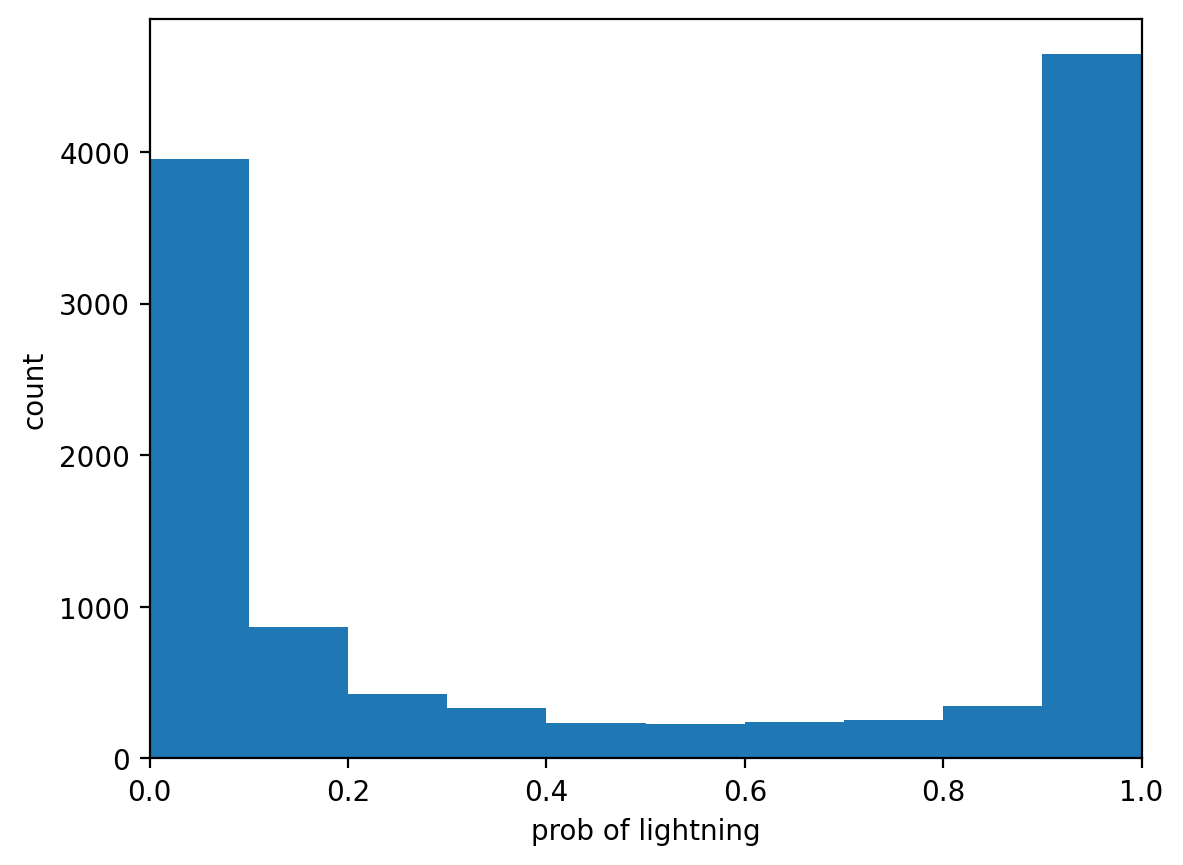

In [21]:
batch_size = 32
_, valid_dl = get_data(train_ds, valid_ds, batch_size)

model.eval()
with torch.no_grad():
    y_preds = torch.cat([model(xb) for xb, _ in valid_dl]).numpy()

plt.hist(y_preds[:, 0])
plt.xlabel("prob of lightning")
plt.ylabel("count")
plt.xlim([0, 1])

学習後のモデルは雷のなし・ありの確率を 0 と 1 に近い値に予測するサンプルが多く、
モデルの出力が分布の中央にある（つまり不確実性が高い）事例が比較的少ないことがわかります。


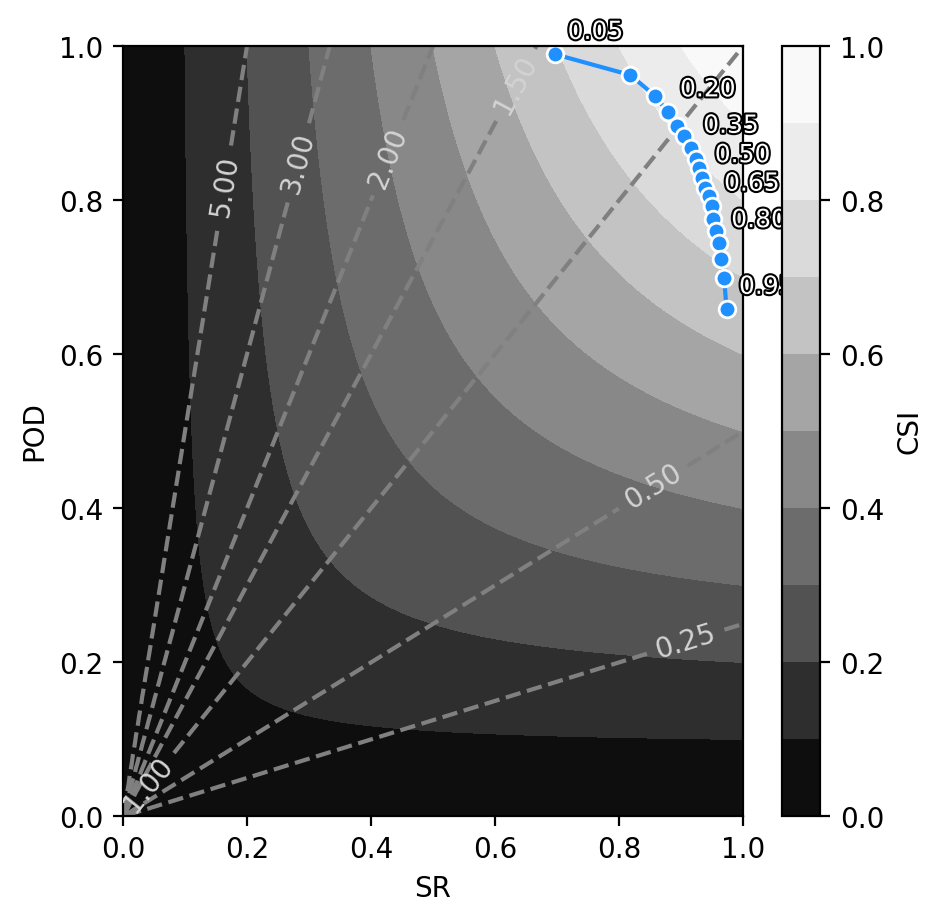

In [22]:
plot_performance_diagram(y_preds[:, 0], valid_ds.tensors[1].numpy())

学習前のモデルに比べはるかに良い結果が得られました。
しきい値 0.2 を雷のなし・ありの分類に使ったときに CSI は最大となり約 0.8 です。

学習後のカーネルフィルターはどのようなフィルターになっているでしょうか？


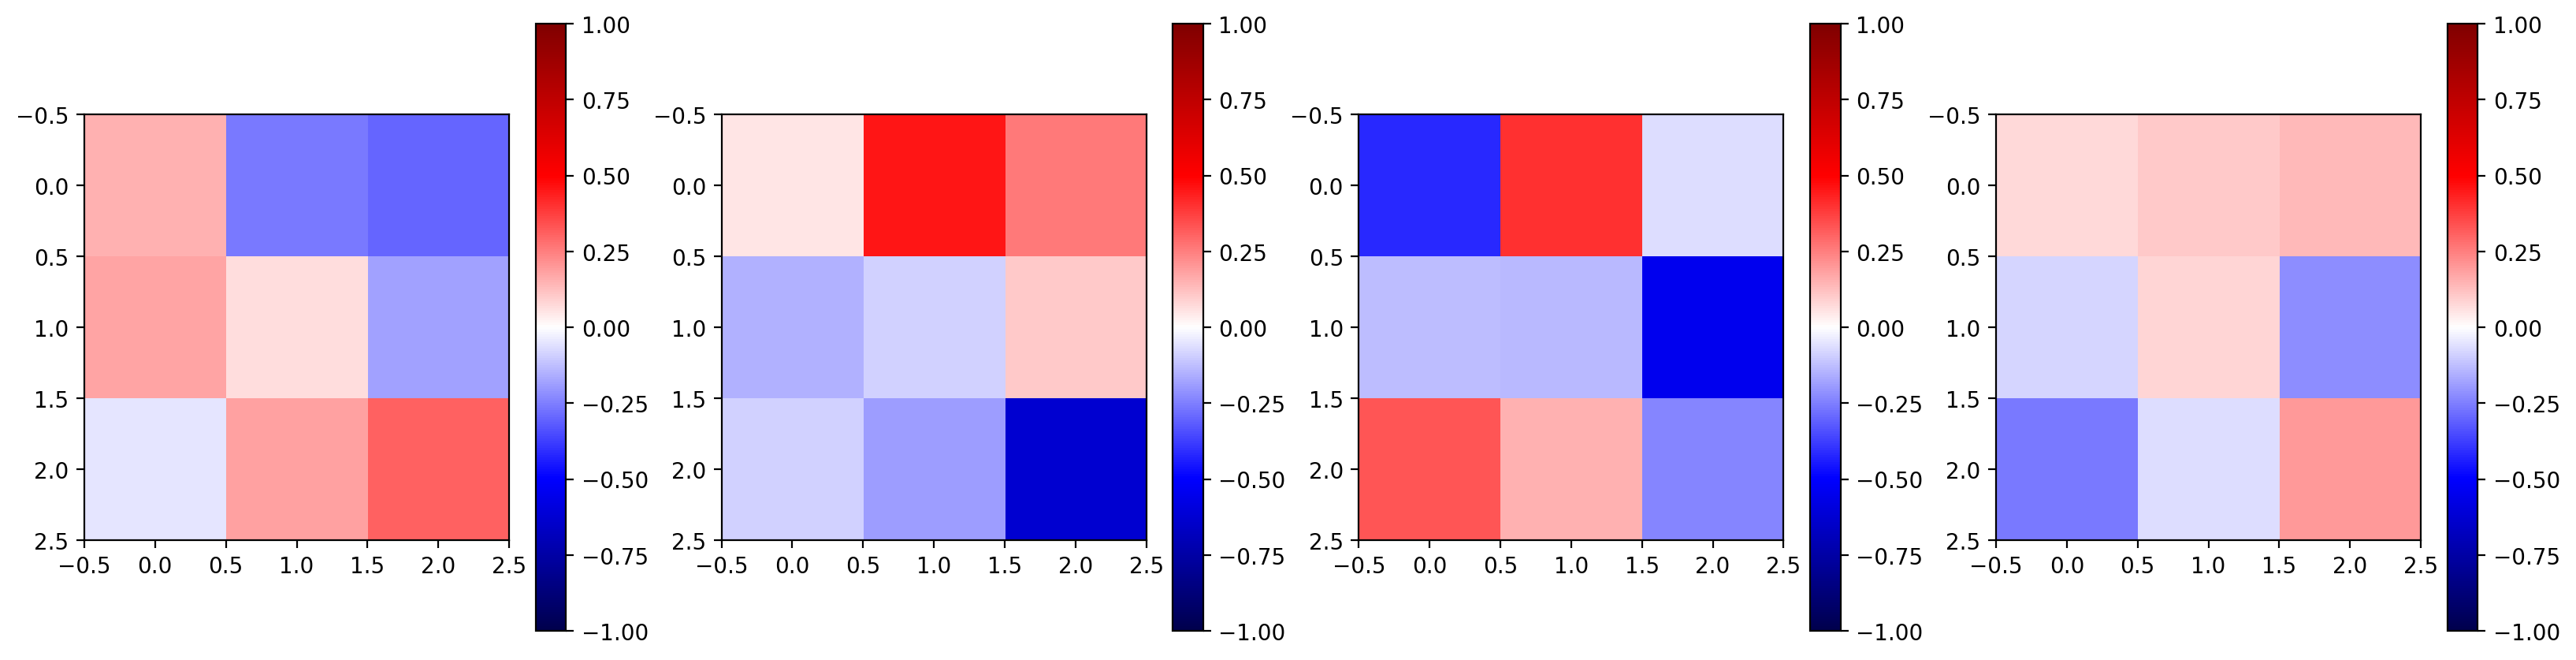

In [23]:
filters = model.conv1.weight.detach().numpy()

fig, axes = plt.subplots(1, 4, figsize=(20, 5))

for i, ax in enumerate(axes):
    pm = ax.imshow(filters[0, i, :, :], vmin=-1, vmax=1, cmap="seismic")
    plt.colorbar(pm, ax=ax)

やはりカーネルそのものを見てもあまり意味がないようなので、畳み込み層の出力を見てみましょう。


In [24]:
conv_layer = nn.Sequential(model.conv1, nn.ReLU())
batch_size = 32
_, valid_dl = get_data(train_ds, valid_ds, batch_size)

conv_layer.eval()
with torch.no_grad():
    xb, yb = next(iter(valid_dl))
    convolved_images = conv_layer(xb)

tensor(1.)


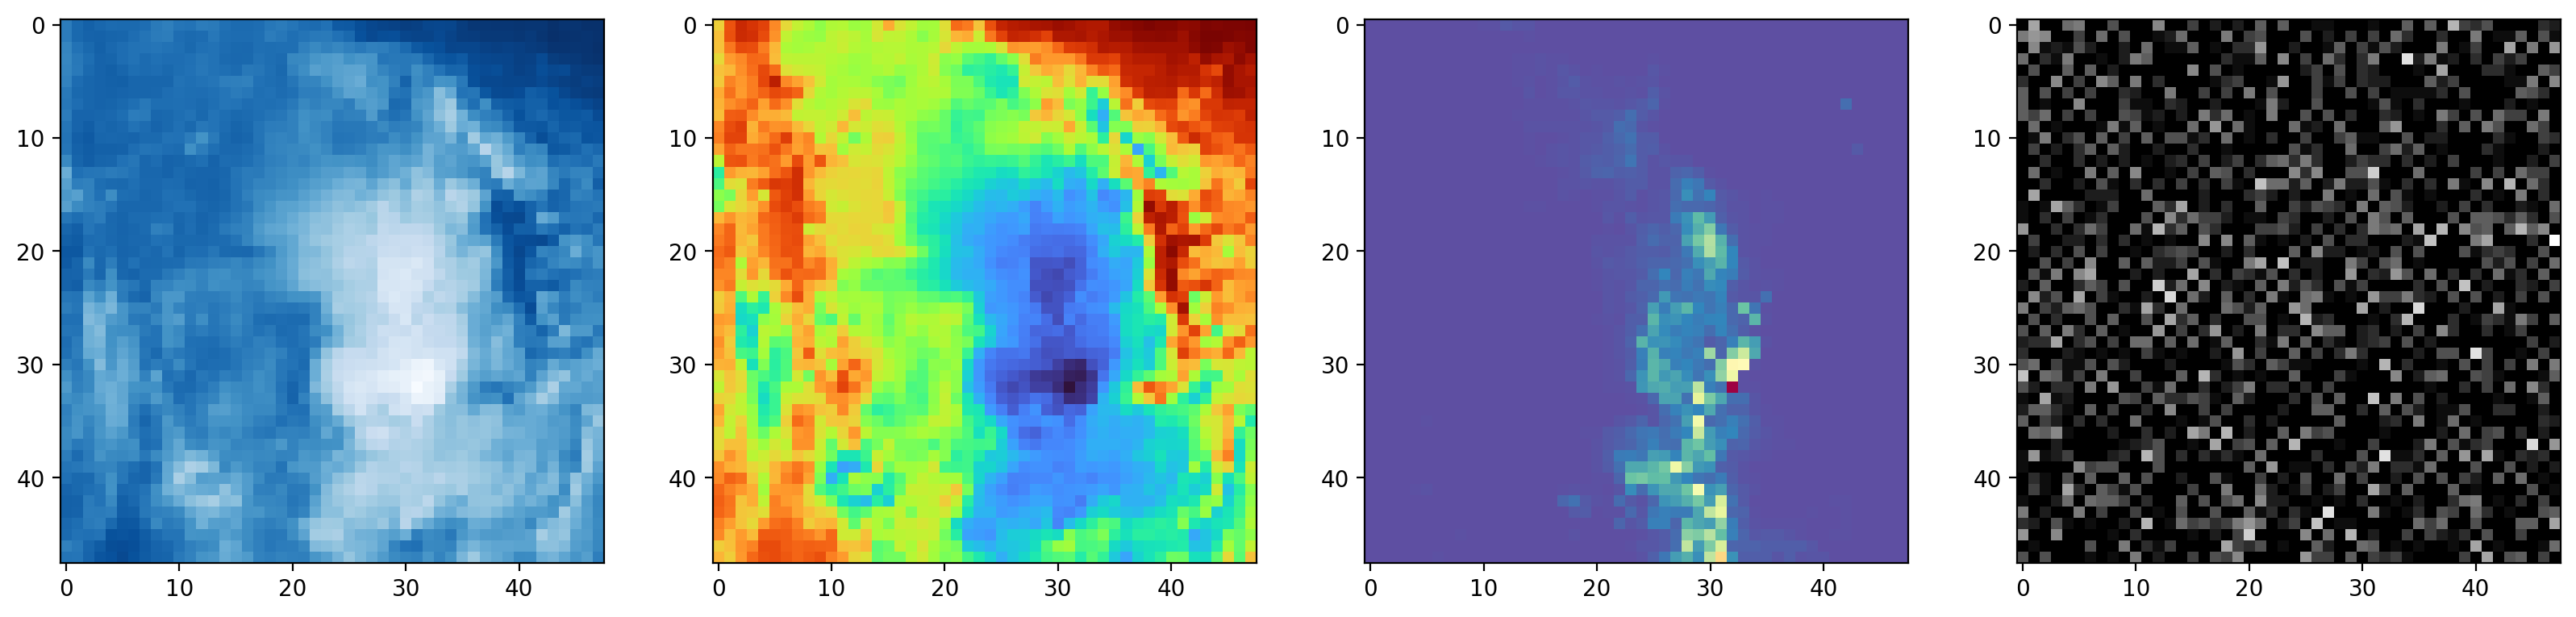

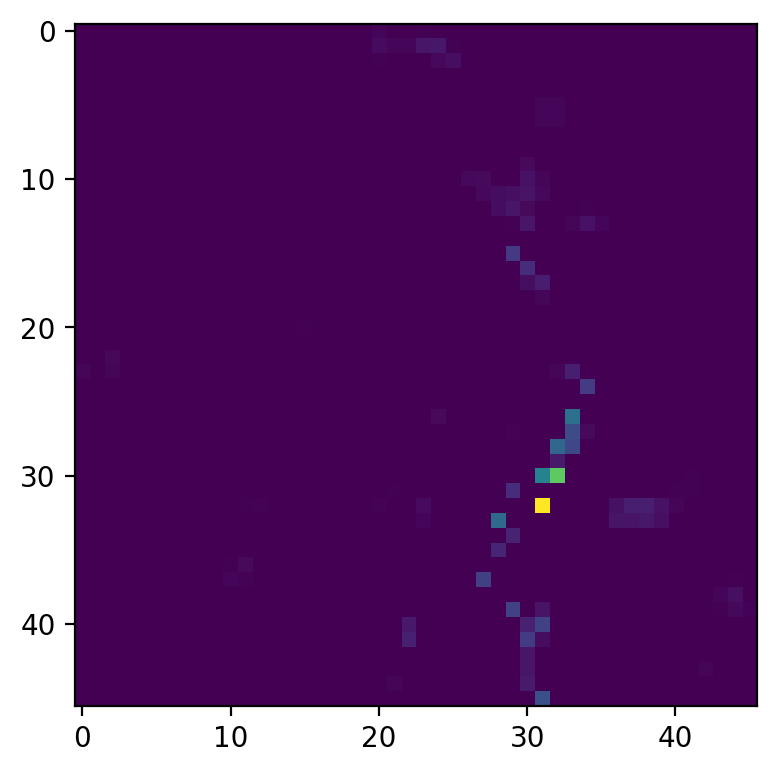

In [25]:
# バッチの0番目の画像
one_example_features = xb[0]
one_example_label = yb[0]

# 入力された画像をプロット
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
axes[0].imshow(one_example_features[0, :, :], cmap="Blues")
axes[1].imshow(one_example_features[1, :, :], cmap="turbo")
axes[2].imshow(one_example_features[2, :, :], cmap="Spectral_r")
axes[3].imshow(one_example_features[3, :, :], cmap="Greys_r")

# ラベルを表示
print(one_example_label)

# 畳み込み層の出力
_, ax = plt.subplots(1, 1, figsize=(4.4, 5))
ax.imshow(convolved_images[0, 0, :, :])

畳み込み層の出力は、輝度温度の低い（冷たい）雲頂と VIL（レーダー）の値が大きい領域にやや集中している分布となり、
訓練前のモデルの畳み込み層の出力とそれほど差がないように見えます。

この結果は、学習済みモデルの動作としてはあまり納得のいく説明ではないと思います。
このチュートリアルの後半で CNN モデルを解釈し説明するより定量的な方法についてのノートを用意しています。


#### ステップ 10： モデルを保存する

よい性能のモデルが得られたのでモデルを保存しておきましょう。


In [26]:
from pathlib import Path

save_dir = Path("../datasets/models/neural_nets_from_notebooks")
save_file = save_dir / "MyFirstCNN.pth"
if not save_dir.exists():
    save_dir.mkdir(parents=True)

torch.save(model, save_file)  # モデルの構造定義ごと保存する

#### ステップ 11：ANN を追加する

一般的に CNN は畳み込み層と最大値プーリング層を持ちますが、
畳み込み層と最大値プーリング層をいくつか繰り返した後に出力を ANN に通します。
このノートで扱った問題は 1 つの畳み込み層だけでよい性能が得られましたが、より完全なモデルにするために ANN を追加しましょう。


In [27]:
class CNN2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=4, out_channels=1, kernel_size=3)
        init_weights(self.conv1)
        self.fc1 = nn.Linear(in_features=(48 - 2) * (48 - 2), out_features=16)
        init_weights(self.fc1)
        self.fc2 = nn.Linear(in_features=16, out_features=32)
        init_weights(self.fc2)
        self.fc3 = nn.Linear(in_features=32, out_features=1)
        init_weights(self.fc3)
        self.flatten = nn.Flatten()

    def forward(self, xb):
        # 畳み込み層
        xb = F.relu(self.conv1(xb))
        xb = self.flatten(xb)
        # 全結合層
        xb = F.relu(self.fc1(xb))
        xb = F.relu(self.fc2(xb))
        # 出力層
        xb = F.sigmoid(self.fc3(xb))
        return xb

model = CNN2()
summary(model)

Layer (type:depth-idx)                   Param #
CNN2                                     --
├─Conv2d: 1-1                            37
├─Linear: 1-2                            33,872
├─Linear: 1-3                            544
├─Linear: 1-4                            33
├─Flatten: 1-5                           --
Total params: 34,486
Trainable params: 34,486
Non-trainable params: 0

学習するパラメータ（重み）の数が増えていることが分かります。


### Step 12: モデルの学習


In [28]:
from tqdm import tqdm

batch_size = 32
train_dl, valid_dl = get_data(train_ds, valid_ds, batch_size)

loss_fn = torch.nn.BCELoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=1e-3)

train_losses = []
valid_losses = []
epochs = np.arange(0, 10) # 10エポック
for epoch in epochs:
    print(f"Epoch {epoch+1}/{len(epochs)}")

    # 学習
    model.train()
    train_loss = 0
    for xb, yb in tqdm(train_dl, total=len(train_dl)):
        pred = model(xb)
        loss = loss_fn(pred, yb.view(-1, 1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    # ミニバッチに対する損失関数から全データに対する損失関数を求める
    train_loss = train_loss / len(train_dl)
    train_losses.append(train_loss)

    # 評価
    model.eval()
    valid_loss = 0
    with torch.no_grad():
        for xb, yb in valid_dl:
            pred = model(xb)
            loss = loss_fn(pred, yb.view(-1, 1))
            valid_loss += loss.item() 

    # ミニバッチに対する損失関数から全データに対する損失関数を求める
    valid_loss = valid_loss / len(valid_dl)
    valid_losses.append(valid_loss)

Epoch 1/10


100%|██████████| 1875/1875 [00:05<00:00, 323.92it/s]


Epoch 2/10


100%|██████████| 1875/1875 [00:05<00:00, 335.58it/s]


Epoch 3/10


100%|██████████| 1875/1875 [00:05<00:00, 355.53it/s]


Epoch 4/10


100%|██████████| 1875/1875 [00:05<00:00, 340.64it/s]


Epoch 5/10


100%|██████████| 1875/1875 [00:05<00:00, 329.97it/s]


Epoch 6/10


100%|██████████| 1875/1875 [00:05<00:00, 329.97it/s]


Epoch 7/10


100%|██████████| 1875/1875 [00:05<00:00, 331.09it/s]


Epoch 8/10


100%|██████████| 1875/1875 [00:05<00:00, 331.63it/s]


Epoch 9/10


100%|██████████| 1875/1875 [00:05<00:00, 323.20it/s]


Epoch 10/10


100%|██████████| 1875/1875 [00:05<00:00, 331.52it/s]


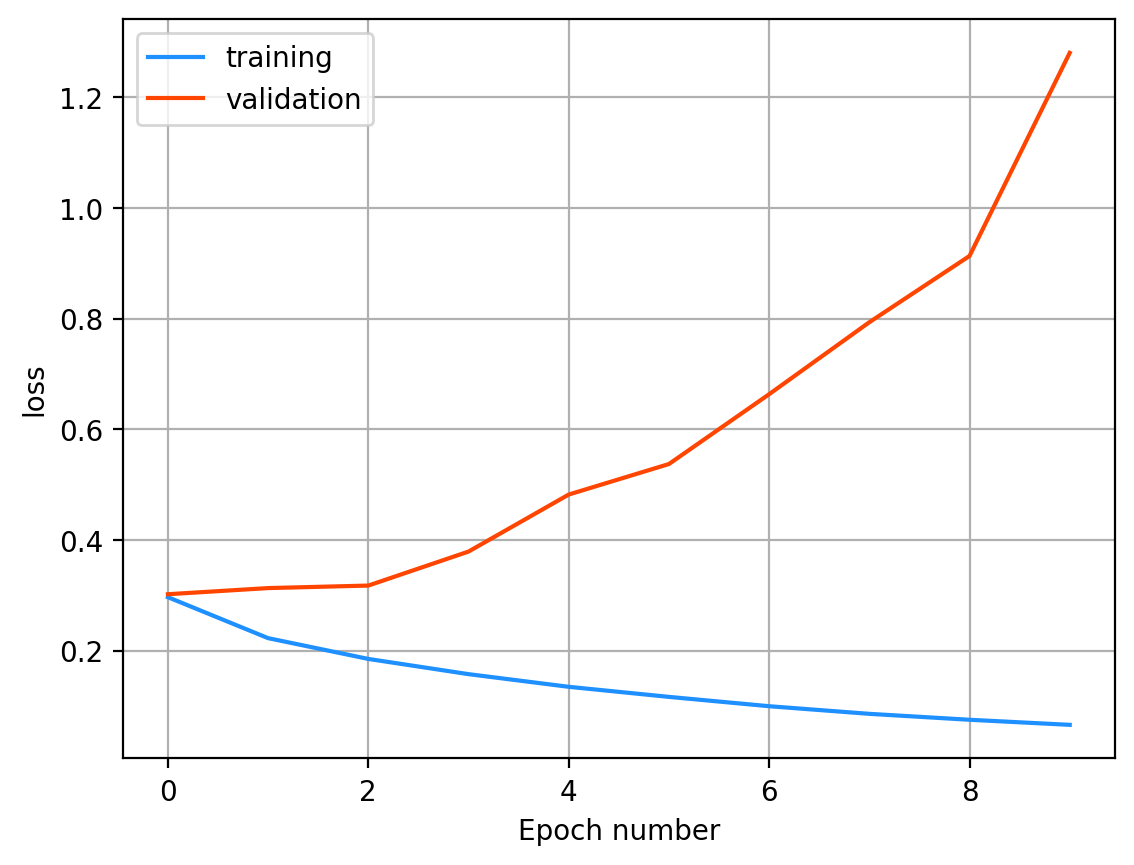

In [29]:
plt.plot(train_losses, color="dodgerblue", label="training")
plt.plot(valid_losses, color="orangered", label="validation")
plt.legend()
plt.xlabel("Epoch number")
plt.ylabel("loss")
plt.grid()

学習曲線は明らかに過学習であることを示しています。
パラメータを増やしてもモデルの性能が上がるわけではないようです。


#### Step 13: 正則化して過学習を修正する

過学習を避けるための正則化（regularization）の手法を導入します。

まずはドロップアウト（dropout）を加えてみましょう。
ドロップアウトとはニューラルネットワークが特定のサンプル
（訓練データの特定のサンプルについての特定の経路）を記憶するのを防ぐために、
ある層のニューロンをランダムに on と off を切り替える手法です。


In [30]:
# nn.Dropout() は eval モードではドロップアウトが無効になる
class CNN3(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=4, out_channels=1, kernel_size=3)
        init_weights(self.conv1)
        self.fc1 = nn.Linear(in_features=(48 - 2) * (48 - 2), out_features=16)
        init_weights(self.fc1)
        self.fc2 = nn.Linear(in_features=16, out_features=32)
        init_weights(self.fc2)
        self.fc3 = nn.Linear(in_features=32, out_features=1)
        init_weights(self.fc3)
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(0.33)

    def forward(self, xb):
        # 畳み込み層
        xb = F.relu(self.conv1(xb))
        xb = self.flatten(xb)
        # 全結合層
        xb = F.relu(self.fc1(xb))
        xb = self.dropout(xb)
        xb = F.relu(self.fc2(xb))
        xb = self.dropout(xb)
        # 出力層
        xb = F.sigmoid(self.fc3(xb))
        return xb

model = CNN3()
summary(model)

Layer (type:depth-idx)                   Param #
CNN3                                     --
├─Conv2d: 1-1                            37
├─Linear: 1-2                            33,872
├─Linear: 1-3                            544
├─Linear: 1-4                            33
├─Flatten: 1-5                           --
├─Dropout: 1-6                           --
Total params: 34,486
Trainable params: 34,486
Non-trainable params: 0

In [31]:
from tqdm import tqdm

batch_size = 32
train_dl, valid_dl = get_data(train_ds, valid_ds, batch_size)

loss_fn = torch.nn.BCELoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=1e-3)

train_losses = []
valid_losses = []
num_epoch = 10
for epoch in range(num_epoch):
    print(f"Epoch {epoch+1}/{num_epoch}")
    model.train()
    train_loss = 0.0
    for xb, yb in tqdm(train_dl, total=len(train_dl)):
        optimizer.zero_grad()
        pred = model(xb)
        loss = loss_fn(pred, yb.view(-1, 1).float())
        loss.backward()
        optimizer.step()
        train_loss += loss.item() 
    train_loss = train_loss / len(train_dl)
    train_losses.append(train_loss)

    # 評価
    model.eval()
    valid_loss = 0.0
    with torch.no_grad():
        for xb, yb in valid_dl:
            pred = model(xb)
            loss = loss_fn(pred, yb.view(-1, 1))
            valid_loss += loss.item()
    valid_loss = valid_loss / len(valid_dl)
    valid_losses.append(valid_loss)

Epoch 1/10


100%|██████████| 1875/1875 [00:05<00:00, 318.27it/s]


Epoch 2/10


100%|██████████| 1875/1875 [00:05<00:00, 325.39it/s]


Epoch 3/10


100%|██████████| 1875/1875 [00:05<00:00, 323.14it/s]


Epoch 4/10


100%|██████████| 1875/1875 [00:05<00:00, 323.84it/s]


Epoch 5/10


100%|██████████| 1875/1875 [00:05<00:00, 321.66it/s]


Epoch 6/10


100%|██████████| 1875/1875 [00:05<00:00, 317.36it/s]


Epoch 7/10


100%|██████████| 1875/1875 [00:05<00:00, 324.63it/s]


Epoch 8/10


100%|██████████| 1875/1875 [00:05<00:00, 324.05it/s]


Epoch 9/10


100%|██████████| 1875/1875 [00:05<00:00, 320.93it/s]


Epoch 10/10


100%|██████████| 1875/1875 [00:05<00:00, 323.18it/s]


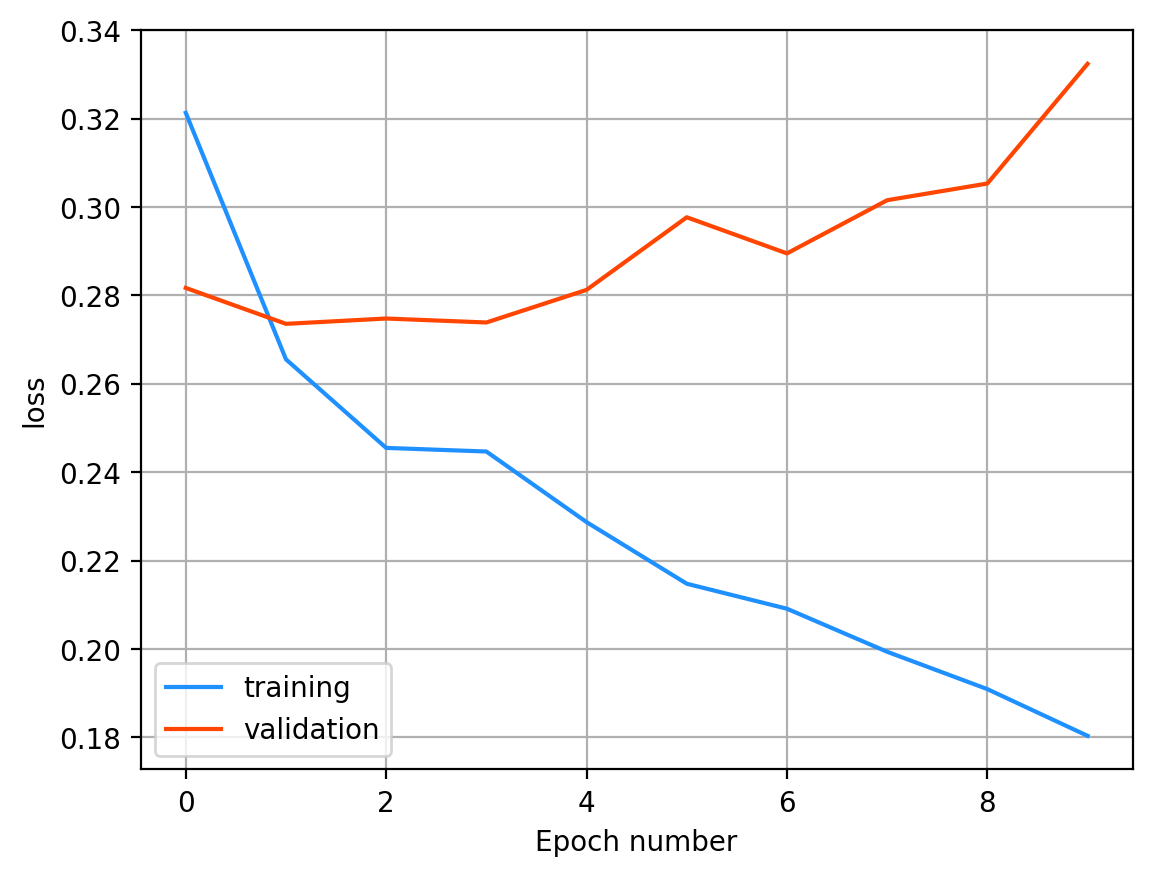

In [32]:
plt.plot(train_losses, color="dodgerblue", label="training")
plt.plot(valid_losses, color="orangered", label="validation")
plt.legend()
plt.xlabel("Epoch number")
plt.ylabel("loss")
plt.grid()

ドロップアウトを加えたことでエポック数 4 あたりまでは評価データの学習曲線は横ばいとなり過学習の程度は弱まりました。しかし、エポック数 5 以降は上昇に転じてしまい過学習の傾向が残っています。

※元論文ではドロップアウトにより過学習がよい抑えられる結果になっており再現することはできなかった。


### Step 14: 性能の確認


(0.0, 1.0)

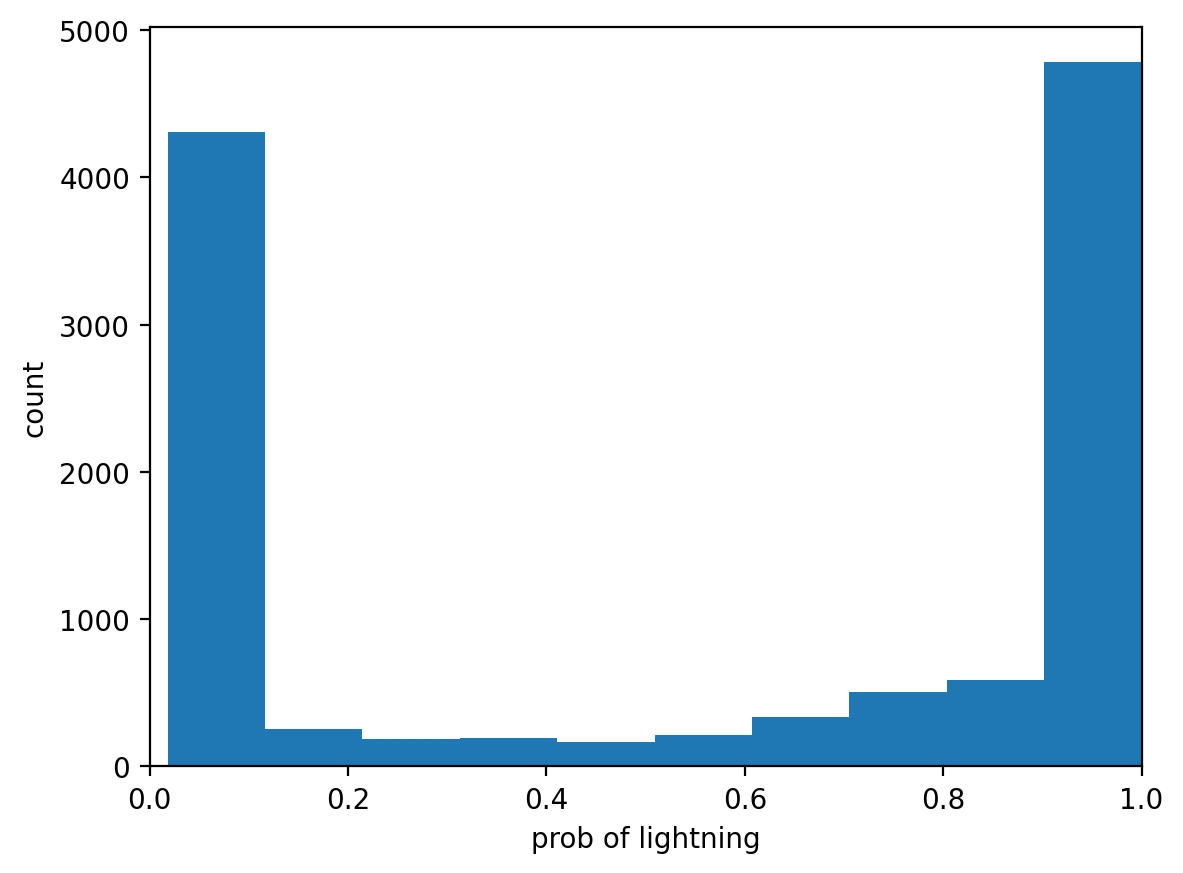

In [33]:
batch_size = 32
_, valid_dl = get_data(train_ds, valid_ds, batch_size)

model.eval()
with torch.no_grad():
    y_preds = torch.cat([model(xb) for xb, _ in valid_dl]).numpy()

plt.hist(y_preds[:, 0])
plt.xlabel("prob of lightning")
plt.ylabel("count")
plt.xlim([0, 1])

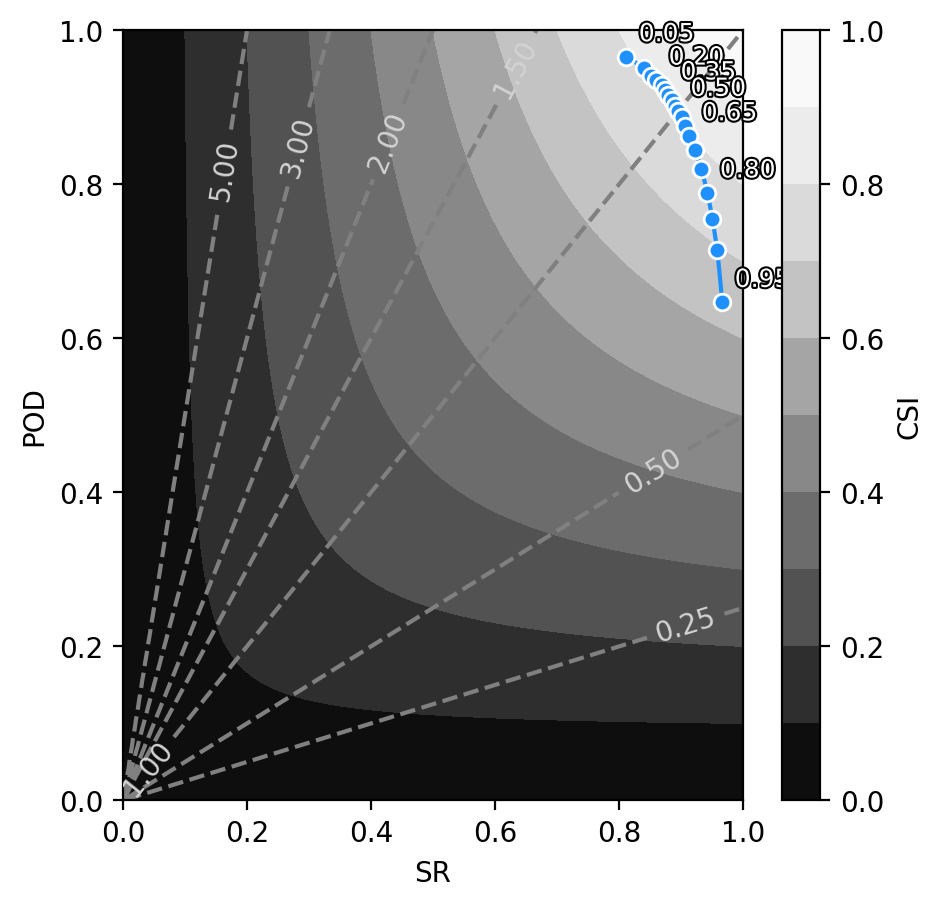

In [34]:
plot_performance_diagram(y_preds[:, 0], valid_ds.tensors[1].numpy())

良い結果が得られています。これで典型的な CNN モデルの学習は終了です。

次のノートでは U-Net を使って学習を行います。
U-Net は画像に雷が含まれるかどうかだけではなく、発雷がどこに分布しているかも予測できます。
